In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

from tqdm import tqdm


In [5]:
# Load clustering preprocessed dataset
folder_name = '../../data/preprocessed_phishing'
folder = folder_name + '/clustering/'
clustering_data_path = os.path.join(folder, 'clustering.csv')
clustering_ready_df = pd.read_csv(clustering_data_path)

clustering_data_path1 = os.path.join(folder, 'clustering_small.csv')
clustering_ready_df_small = pd.read_csv(clustering_data_path1)

X_pca = clustering_ready_df.values  # PCA-transformed features
X_pca1 = clustering_ready_df_small.values

# Analyze original labels in clusters
balanced_df_path = os.path.join(folder_name, 'subset.csv')
balanced_df = pd.read_csv(balanced_df_path)

balanced_df_path1 = os.path.join(folder_name, 'smaller_subset.csv')
balanced_df1 = pd.read_csv(balanced_df_path1)

In [25]:
# Apply KMeans clustering with 2 clusters for legitimate and phishing
kmeans = KMeans(n_clusters=2, random_state=4, n_init=10)
kcluster_labels = kmeans.fit_predict(X_pca)

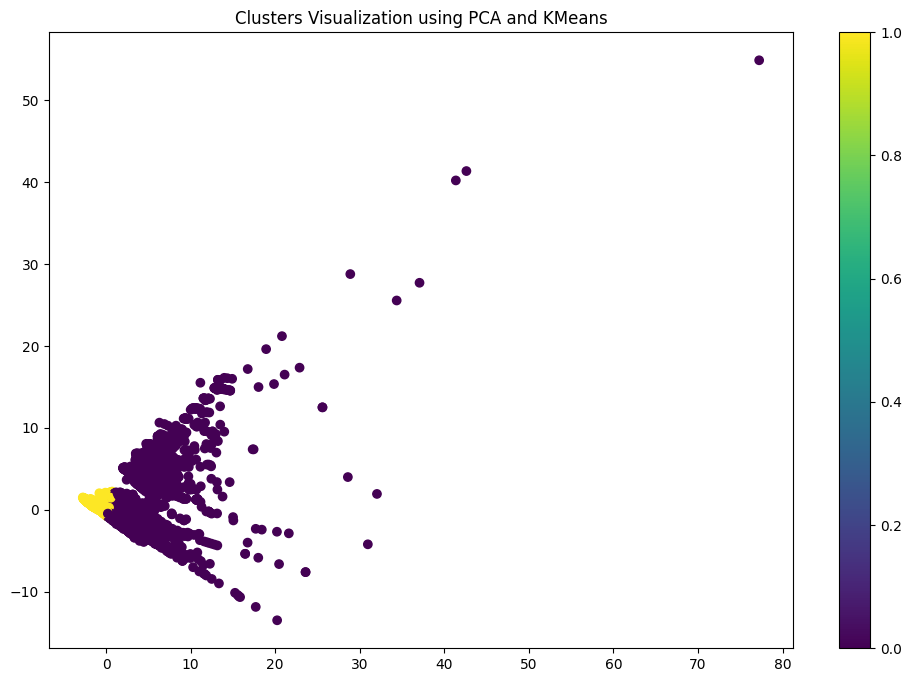

In [26]:
# Plot clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kcluster_labels, cmap='viridis')
plt.title('Clusters Visualization using PCA and KMeans')
plt.colorbar(scatter)
plt.show()

In [28]:
# Analyze cluster distribution
cluster_counts = pd.Series(kcluster_labels).value_counts()
print("Cluster counts:\n", cluster_counts)


kmeans_analysis = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels
})

kcluster_label_counts = kmeans_analysis.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)
print("KMeans Cluster Analysis:\n", kcluster_label_counts)

Cluster counts:
 1    60526
0    39474
Name: count, dtype: int64
KMeans Cluster Analysis:
 original_label  legitimate  phishing
cluster_label                       
0                     6417     33057
1                    43583     16943


In [29]:

# Define confusion matrix values
TP = kcluster_label_counts.loc[0, 'phishing']
TN = kcluster_label_counts.loc[1, 'legitimate']
FP = kcluster_label_counts.loc[0, 'legitimate']
FN = kcluster_label_counts.loc[1, 'phishing']

# Create true and predicted arrays based on these values
true_labels = [1] * TP + [1] * FN + [0] * TN + [0] * FP
predicted_labels = [1] * TP + [0] * FN + [0] * TN + [1] * FP

# Calculate metrics using sklearn functions
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.7664
Precision: 0.837437300501596
Recall: 0.66114
F1 Score: 0.7389185685226992


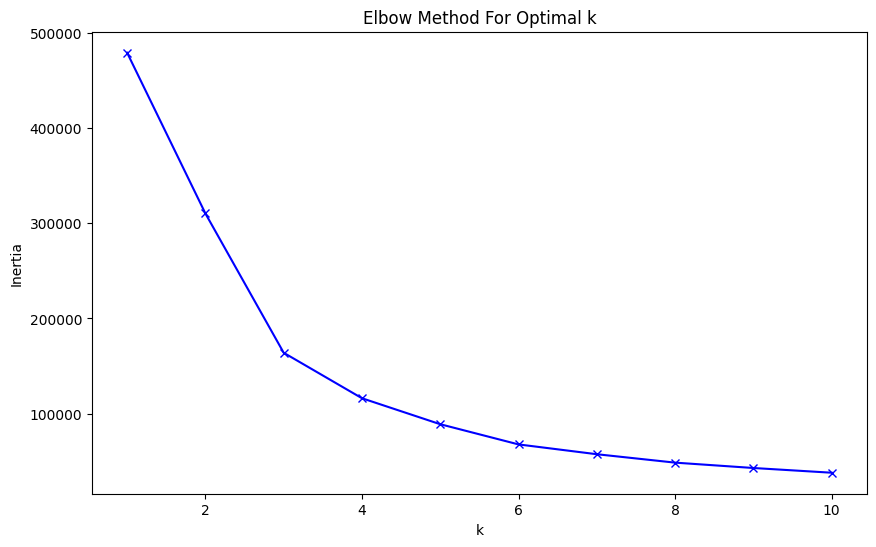

In [30]:
# Determine optimal number of clusters using elbow method
inertias = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

In [31]:
# using 3 clusters as seen from elbow method
kmeans1 = KMeans(n_clusters=3, random_state=42, n_init=10)
kcluster_labels1 = kmeans1.fit_predict(X_pca)

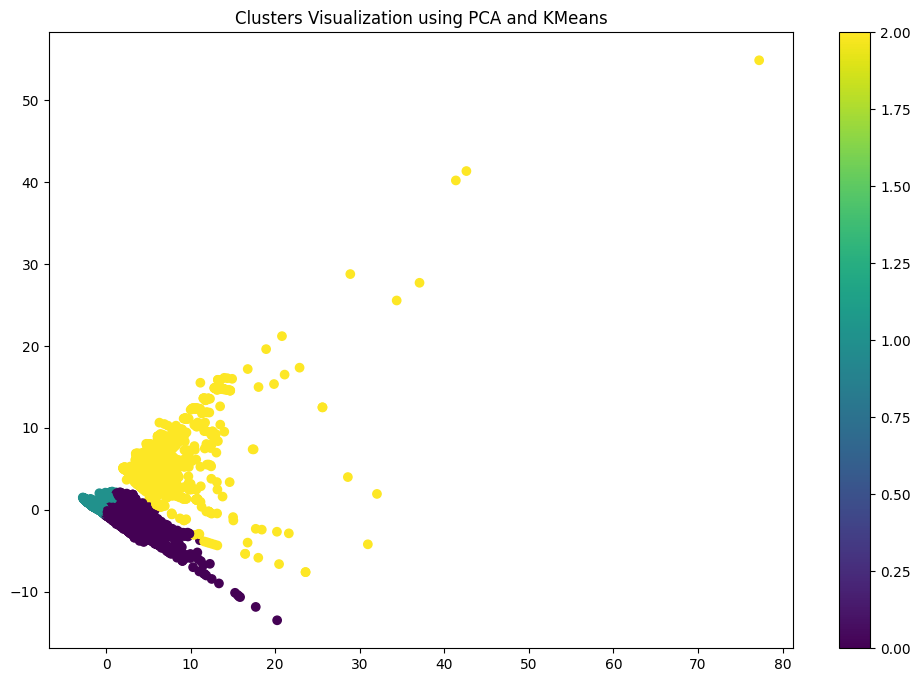

In [32]:
# Plot clusters
plt.figure(figsize=(12, 8))
scatter1 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kcluster_labels1, cmap='viridis')
plt.title('Clusters Visualization using PCA and KMeans')
plt.colorbar(scatter1)
plt.show()

In [33]:
# Create a DataFrame with the original labels and the kmeans cluster labels
kmeans_analysis1 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels1
})

# Group by cluster label and count the occurrences of each original label
kcluster_label_counts1 = kmeans_analysis1.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(kcluster_label_counts1)

original_label  legitimate  phishing
cluster_label                       
0                     8066     34946
1                    41934     12257
2                        0      2797


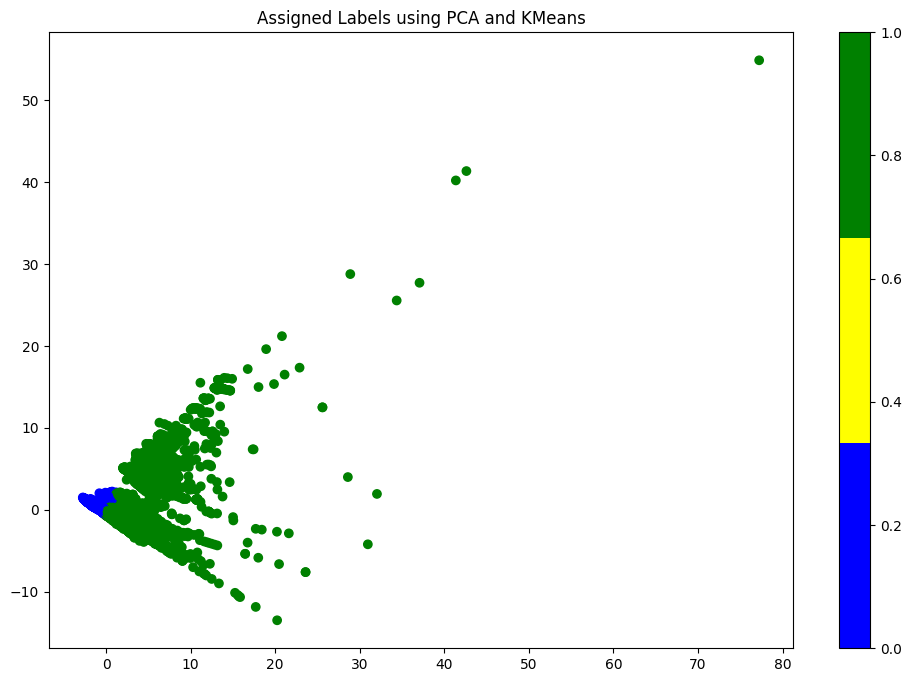

In [34]:
# Create a new column to assign labels to the clusters

legitimate_clusters = [1]
phishing_clusters = [0, 2]

clustered_df = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels1
})

clustered_df['assigned_label'] = clustered_df['cluster_label'].apply(lambda x: 0 if x in legitimate_clusters else 1 if x in phishing_clusters else 2)

# Create a custom colormap with specific colors for each label
cmap = mcolors.ListedColormap(['blue', 'yellow', 'green'])

# Plot the assigned labels
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clustered_df['assigned_label'], cmap=cmap)
plt.title('Assigned Labels using PCA and KMeans')
plt.colorbar(scatter)
plt.show()

In [35]:
# Count the number of legitimate and phishing labels in each assigned cluster
assigned_label_counts = clustered_df.groupby('assigned_label')['original_label'].value_counts().unstack(fill_value=0)

print(assigned_label_counts)

original_label  legitimate  phishing
assigned_label                      
0                    41934     12257
1                     8066     37743


In [36]:

# Define confusion matrix values
TP = assigned_label_counts.loc[1, 'phishing'] #phishing correctly identified
TN = assigned_label_counts.loc[0, 'legitimate'] #legitimate correctly identified
FP = assigned_label_counts.loc[1, 'legitimate'] #legitimate identified as phishing
FN = assigned_label_counts.loc[0, 'phishing']

# Create true and predicted arrays based on these values
true_labels = [1] * TP + [1] * FN + [0] * TN + [0] * FP
predicted_labels = [1] * TP + [0] * FN + [0] * TN + [1] * FP

# Calculate metrics using sklearn functions
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.79677
Precision: 0.8239210635464647
Recall: 0.75486
F1 Score: 0.7878800530221586


Evaluating KMeans Clusters: 100%|██████████| 9/9 [13:02<00:00, 86.98s/it]
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed i

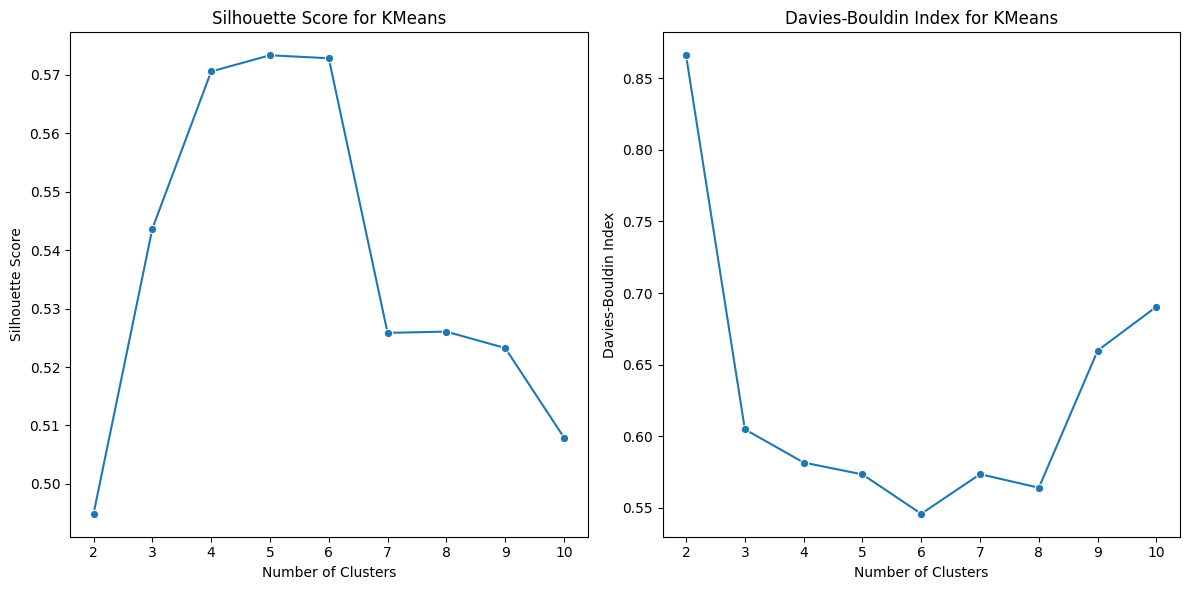

Best number of clusters based on Silhouette Score: 5 (Score: 0.5734)
Best number of clusters based on Davies-Bouldin Index: 6 (Score: 0.5458)


In [43]:
# Step 1: Evaluate KMeans for a range of cluster numbers with tqdm for progress tracking
def evaluate_kmeans(X_pca, cluster_range):
    silhouette_scores = []
    db_scores = []
    results = []

    for k in tqdm(cluster_range, desc="Evaluating KMeans Clusters"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_pca)
        
        # Compute Silhouette Score and Davies-Bouldin Index
        silhouette = silhouette_score(X_pca, labels) if k > 1 else -1  # Silhouette not valid for k=1
        db_index = davies_bouldin_score(X_pca, labels) if k > 1 else float('inf')
        
        silhouette_scores.append(silhouette)
        db_scores.append(db_index)
        
        results.append((k, silhouette, db_index))

    return results, silhouette_scores, db_scores

# Step 2: Define cluster range and compute metrics
cluster_range = range(2, 11)  # Test cluster sizes from 2 to 10
results, silhouette_scores, db_scores = evaluate_kmeans(X_pca, cluster_range)

# Convert results to DataFrame for easier plotting
results_df = pd.DataFrame(results, columns=['Clusters', 'Silhouette Score', 'Davies-Bouldin Index'])

# Step 3: Plot the metrics
plt.figure(figsize=(12, 6))

# Plot Silhouette Score
plt.subplot(1, 2, 1)
sns.lineplot(data=results_df, x='Clusters', y='Silhouette Score', marker='o')
plt.title('Silhouette Score for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

# Plot Davies-Bouldin Index
plt.subplot(1, 2, 2)
sns.lineplot(data=results_df, x='Clusters', y='Davies-Bouldin Index', marker='o')
plt.title('Davies-Bouldin Index for KMeans')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

# Step 4: Print the best results
best_silhouette_index = results_df['Silhouette Score'].idxmax()
best_silhouette_clusters = results_df.loc[best_silhouette_index, 'Clusters']
best_silhouette_score = results_df.loc[best_silhouette_index, 'Silhouette Score']

best_db_index = results_df['Davies-Bouldin Index'].idxmin()
best_db_clusters = results_df.loc[best_db_index, 'Clusters']
best_db_score = results_df.loc[best_db_index, 'Davies-Bouldin Index']

print(f"Best number of clusters based on Silhouette Score: {best_silhouette_clusters} (Score: {best_silhouette_score:.4f})")
print(f"Best number of clusters based on Davies-Bouldin Index: {best_db_clusters} (Score: {best_db_score:.4f})")

In [37]:
# Best number of clusters based on Silhouette Score: 5 (Score: 0.5734)
kmeans5 = KMeans(n_clusters=5, random_state=42, n_init=10)
kcluster_labels5 = kmeans5.fit_predict(X_pca)
# Create a DataFrame with the original labels and the kmeans cluster labels
kmeans_analysis5 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels5
})

# Group by cluster label and count the occurrences of each original label
kcluster_label_counts5 = kmeans_analysis5.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(kcluster_label_counts5)

# Create a new column to assign labels to the clusters

legitimate_clusters = [1]
phishing_clusters = [0, 2, 3, 4]

clustered_df = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels5
})

clustered_df['assigned_label'] = clustered_df['cluster_label'].apply(lambda x: 0 if x in legitimate_clusters else 1 if x in phishing_clusters else 2)

# Count the number of legitimate and phishing labels in each assigned cluster
assigned_label_counts = clustered_df.groupby('assigned_label')['original_label'].value_counts().unstack(fill_value=0)

print(assigned_label_counts)


# Define confusion matrix values
TP = assigned_label_counts.loc[1, 'phishing'] #phishing correctly identified
TN = assigned_label_counts.loc[0, 'legitimate'] #legitimate correctly identified
FP = assigned_label_counts.loc[1, 'legitimate'] #legitimate identified as phishing
FN = assigned_label_counts.loc[0, 'phishing']

# Create true and predicted arrays based on these values
true_labels = [1] * TP + [1] * FN + [0] * TN + [0] * FP
predicted_labels = [1] * TP + [0] * FN + [0] * TN + [1] * FP

# Calculate metrics using sklearn functions
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

original_label  legitimate  phishing
cluster_label                       
0                    10616     33041
1                    37421      2298
2                        0      2602
3                     1963     11885
4                        0       174
original_label  legitimate  phishing
assigned_label                      
0                    37421      2298
1                    12579     47702
Accuracy: 0.85123
Precision: 0.7913272838871286
Recall: 0.95404
F1 Score: 0.865099155792929


In [38]:
# Best number of clusters based on Davies-Bouldin Index: 6 (Score: 0.5458)
kmeans6 = KMeans(n_clusters=6, random_state=42, n_init=10)
kcluster_labels6 = kmeans6.fit_predict(X_pca)
# Create a DataFrame with the original labels and the kmeans cluster labels
kmeans_analysis6 = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels6
})

# Group by cluster label and count the occurrences of each original label
kcluster_label_counts6 = kmeans_analysis6.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(kcluster_label_counts6)

# Create a new column to assign labels to the clusters

legitimate_clusters = [0]
phishing_clusters = [1, 2, 3, 4, 5]

clustered_df = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': kcluster_labels6
})

clustered_df['assigned_label'] = clustered_df['cluster_label'].apply(lambda x: 0 if x in legitimate_clusters else 1 if x in phishing_clusters else 2)

# Count the number of legitimate and phishing labels in each assigned cluster
assigned_label_counts = clustered_df.groupby('assigned_label')['original_label'].value_counts().unstack(fill_value=0)

print(assigned_label_counts)


# Define confusion matrix values
TP = assigned_label_counts.loc[1, 'phishing'] #phishing correctly identified
TN = assigned_label_counts.loc[0, 'legitimate'] #legitimate correctly identified
FP = assigned_label_counts.loc[1, 'legitimate'] #legitimate identified as phishing
FN = assigned_label_counts.loc[0, 'phishing']

# Create true and predicted arrays based on these values
true_labels = [1] * TP + [1] * FN + [0] * TN + [0] * FP
predicted_labels = [1] * TP + [0] * FN + [0] * TN + [1] * FP

# Calculate metrics using sklearn functions
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

original_label  legitimate  phishing
cluster_label                       
0                    36479      1702
1                    10763     30181
2                        0      2545
3                        0       173
4                     2573     14284
5                      185      1115
original_label  legitimate  phishing
assigned_label                      
0                    36479      1702
1                    13521     48298
Accuracy: 0.84777
Precision: 0.7812808359889355
Recall: 0.96596
F1 Score: 0.8638603457373076


**Both Silhouette score and Davies-Bouldin give us better results than the elbow method**

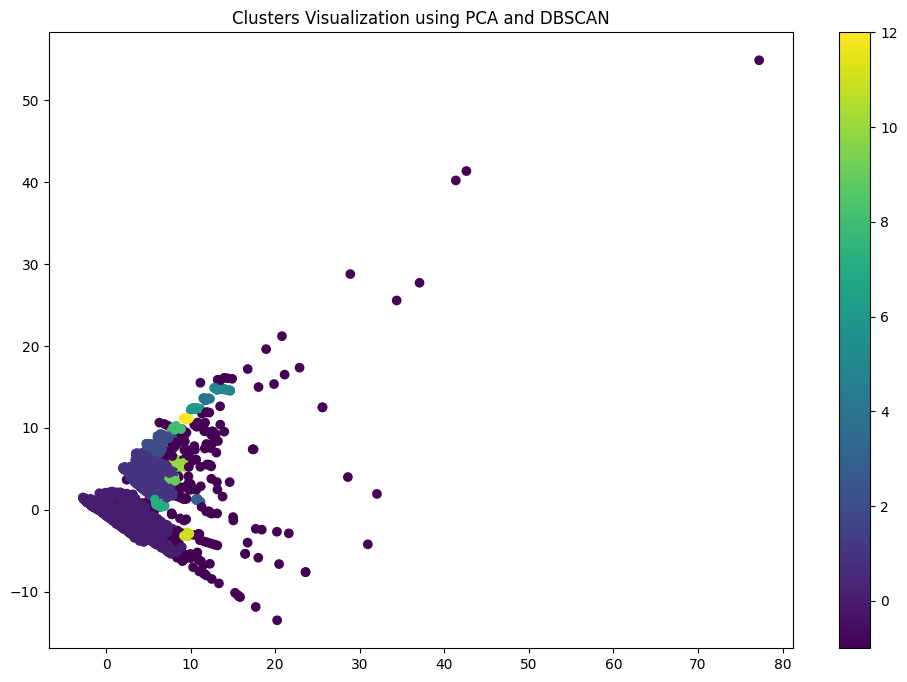

In [39]:
# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_pca)

# Plot clusters using DBSCAN
plt.figure(figsize=(12, 8))
scatter2 = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, cmap='viridis')
plt.title('Clusters Visualization using PCA and DBSCAN')
plt.colorbar(scatter2)
plt.show()

In [40]:
# Create a DataFrame with the original labels and the DBSCAN cluster labels
dbscan_analysis = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': dbscan_labels
})

# Group by cluster label and count the occurrences of each original label
dbscan_label_counts = dbscan_analysis.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(dbscan_label_counts)

original_label  legitimate  phishing
cluster_label                       
-1                      17       220
 0                   49983     47158
 1                       0      2219
 2                       0       186
 3                       0        20
 4                       0        15
 5                       0        68
 6                       0        18
 7                       0        18
 8                       0        19
 9                       0        14
 10                      0        24
 11                      0        10
 12                      0        11


The clustering here using dbscan do not seem to differentiate the target classes, hence we try tuning parameters to get better clusters

eps values: 100%|██████████| 3/3 [30:45<00:00, 615.25s/it]        
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping wi

Best DBSCAN parameters based on Silhouette Score: eps=0.6, min_samples=20
Best DBSCAN parameters based on Davies-Bouldin Index: eps=0.6, min_samples=40


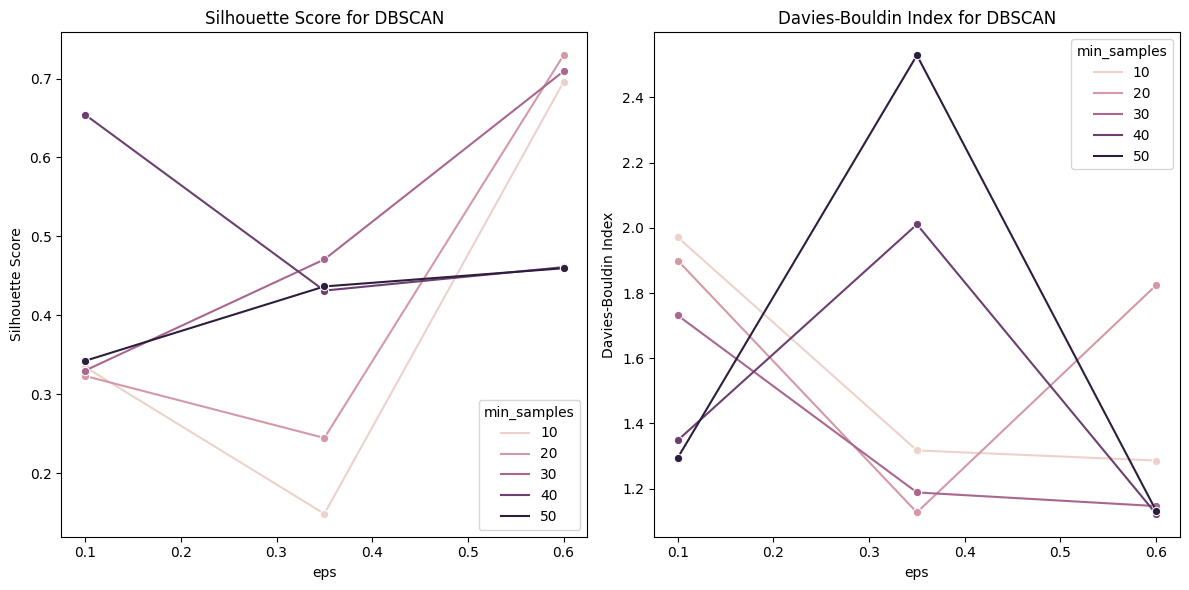

In [9]:
# Step 1: Compute the k-Nearest Neighbors distance
def compute_knn_distances(X_pca, n_neighbors):
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(X_pca)
    distances, _ = knn.kneighbors(X_pca)
    sorted_distances = np.sort(distances[:, n_neighbors - 1])
    return sorted_distances

# Step 2: Plot the k-NN distance plot to find a suitable eps
def plot_knn_distance(X_pca, n_neighbors=10):
    sorted_distances = compute_knn_distances(X_pca, n_neighbors)
    plt.figure(figsize=(12, 8))
    plt.plot(sorted_distances)
    plt.title(f'k-NN Distance Plot (k={n_neighbors})')
    plt.xlabel('Data Points sorted by distance')
    plt.ylabel(f'Distance to {n_neighbors}-th nearest neighbor')
    plt.grid(True)
    plt.show()

# Step 3: Automatic selection of eps and min_samples based on Silhouette Score or Davies-Bouldin Index
def dbscan_auto_select(X_pca, eps_values, min_samples_range):
    best_silhouette = -1
    best_db_index = float('inf')
    best_params_silhouette = {}
    best_params_db_index = {}
    results = []

    for eps in tqdm(eps_values, desc="eps values"):
        for min_samples in tqdm(min_samples_range, desc="min_samples values", leave=False):
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            clusters = dbscan.fit_predict(X_pca)

            if len(np.unique(clusters)) > 1:
                silhouette = silhouette_score(X_pca, clusters)
                db_index = davies_bouldin_score(X_pca, clusters)
                results.append((eps, min_samples, silhouette, db_index))

                if silhouette > best_silhouette:
                    best_silhouette = silhouette
                    best_params_silhouette = {'eps': eps, 'min_samples': min_samples}

                if db_index < best_db_index:
                    best_db_index = db_index
                    best_params_db_index = {'eps': eps, 'min_samples': min_samples}

    return results, best_params_silhouette, best_params_db_index

# Step 4: Automatically choose the best eps and min_samples values based on performance metrics
eps_values = np.linspace(0.1, 0.6, 3)
min_samples_range = range(10, 60, 10)

# Experiment with different n_neighbors values
n_neighbors_values = [2, 3, 5, 10]

# for n_neighbors in n_neighbors_values:
#     print(f"Plotting k-NN distance plot for n_neighbors={n_neighbors}")
#     plot_knn_distance(X_pca, n_neighbors)

results, best_params_silhouette, best_params_db_index = dbscan_auto_select(X_pca, eps_values, min_samples_range)

# Step 5: Print best DBSCAN configuration and results
print(f"Best DBSCAN parameters based on Silhouette Score: eps={best_params_silhouette['eps']}, min_samples={best_params_silhouette['min_samples']}")
print(f"Best DBSCAN parameters based on Davies-Bouldin Index: eps={best_params_db_index['eps']}, min_samples={best_params_db_index['min_samples']}")

# Step 6: Plot the Silhouette and Davies-Bouldin scores
results_df = pd.DataFrame(results, columns=['eps', 'min_samples', 'Silhouette Score', 'Davies-Bouldin Index'])

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.lineplot(data=results_df, x='eps', y='Silhouette Score', hue='min_samples', marker='o')
plt.title('Silhouette Score for DBSCAN')
plt.xlabel('eps')
plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
sns.lineplot(data=results_df, x='eps', y='Davies-Bouldin Index', hue='min_samples', marker='o')
plt.title('Davies-Bouldin Index for DBSCAN')
plt.xlabel('eps')
plt.ylabel('Davies-Bouldin Index')

plt.tight_layout()
plt.show()

original_label  legitimate  phishing
cluster_label                       
-1                      16       335
 0                   49984     47161
 1                       0      2219
 2                       0       175
 3                       0        20
 4                       0        68
 5                       0        22


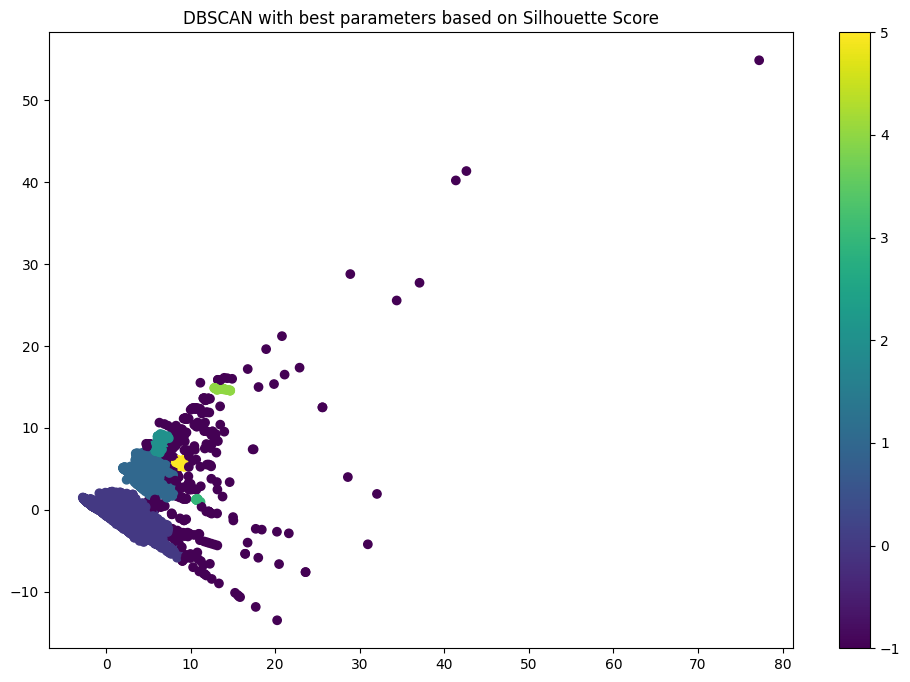

In [17]:
# Best DBSCAN parameters based on Silhouette Score: eps=0.6, min_samples=20
dbscanS = DBSCAN(eps=0.6, min_samples=20)
dbscan_labelsS = dbscanS.fit_predict(X_pca)

# Create a DataFrame with the original labels and the DBSCAN cluster labels
cluster_analysisS = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': dbscan_labelsS
})

# Group by cluster label and count the occurrences of each original label
cluster_label_countsS = cluster_analysisS.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(cluster_label_countsS)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labelsS, cmap='viridis')
plt.title('DBSCAN with best parameters based on Silhouette Score')
plt.colorbar(scatter)
plt.show()

original_label  legitimate  phishing
cluster_label                       
-1                      30       474
 0                   49935     46653
 1                       0      1655
 2                       0       551
 3                      24       399
 4                       0       151
 5                      11        54
 6                       0        63


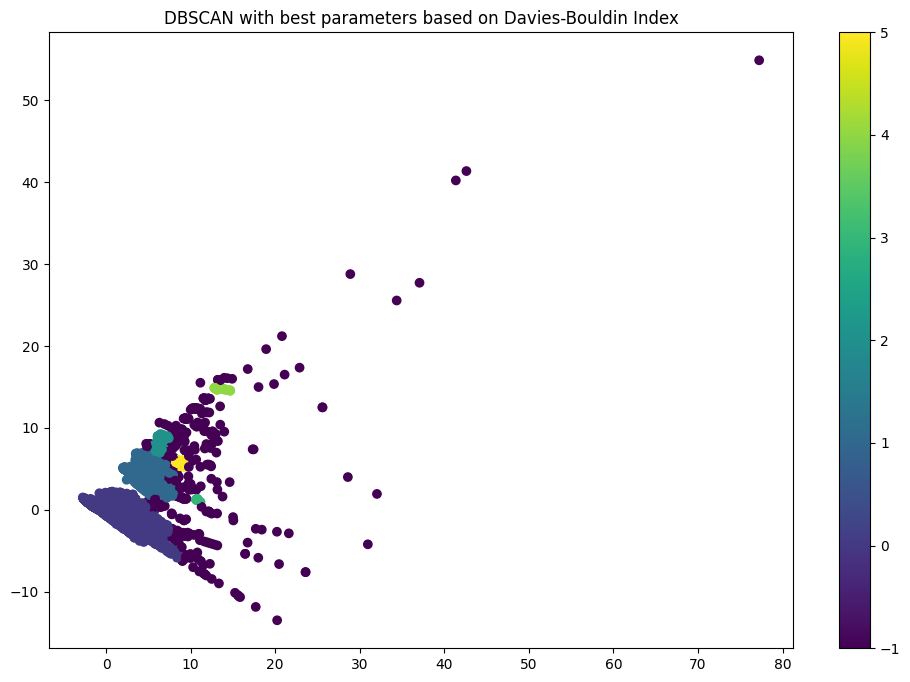

In [18]:
# Best DBSCAN parameters based on Davies-Bouldin Index: eps=0.6, min_samples=40
dbscanD = DBSCAN(eps=0.6, min_samples=40)
dbscan_labelsD = dbscanD.fit_predict(X_pca)

# Create a DataFrame with the original labels and the DBSCAN cluster labels
cluster_analysisD = pd.DataFrame({
    'original_label': balanced_df['label'],
    'cluster_label': dbscan_labelsD
})

# Group by cluster label and count the occurrences of each original label
cluster_label_countsD = cluster_analysisD.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(cluster_label_countsD)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labelsS, cmap='viridis')
plt.title('DBSCAN with best parameters based on Davies-Bouldin Index')
plt.colorbar(scatter)
plt.show()

**We see most of both legitimate and phishing are still assigned to one cluster and hence DBSCAN, even with the best params are not suitable for this dataset.**

Clustering Progress: 100%|██████████| 5/5 [00:22<00:00,  4.48s/it]


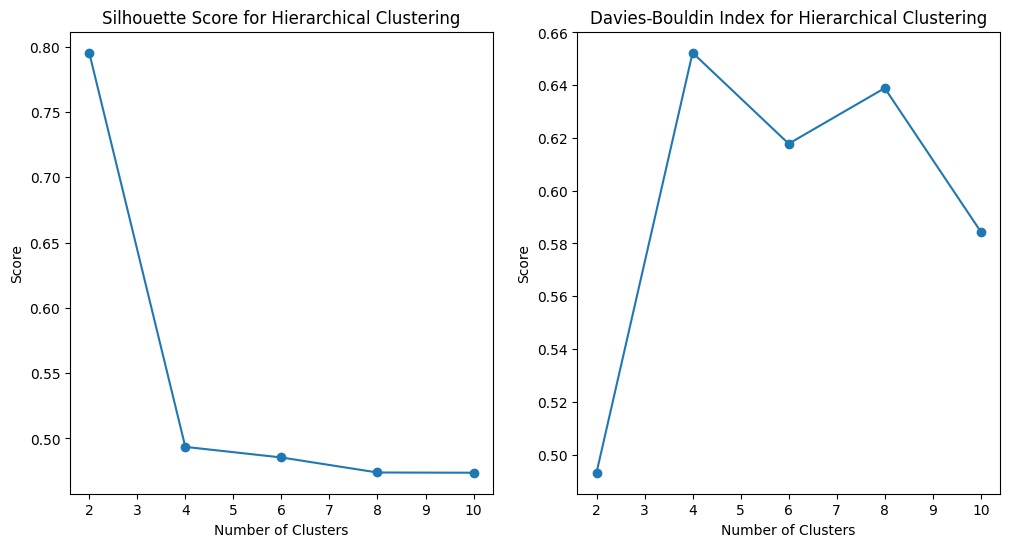

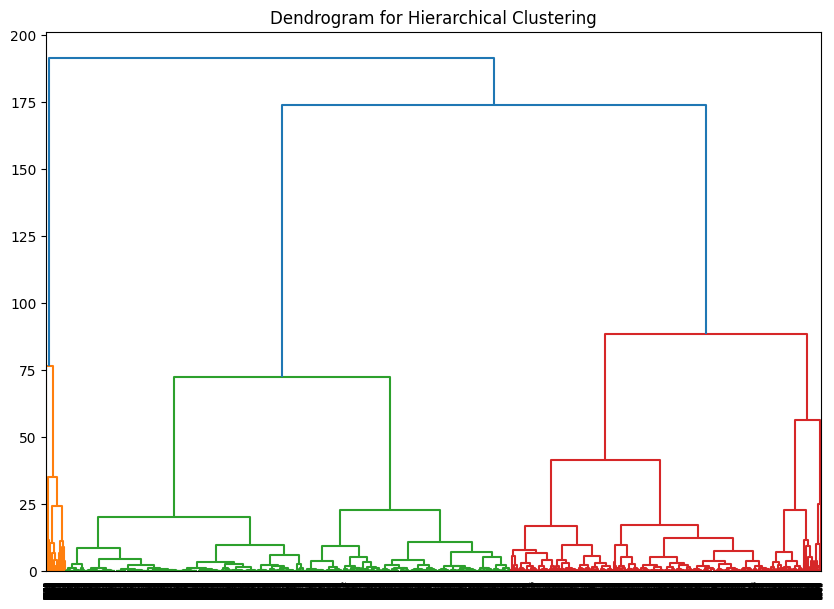

Best number of clusters based on Silhouette Score: 2 (Score: 0.7955)
Best number of clusters based on Davies-Bouldin Index: 2 (Score: 0.4931)


In [4]:
# Step 1: Perform Agglomerative Clustering
def hierarchical_clustering(X_pca1, num_clusters, linkage_method='ward'):
    hc = AgglomerativeClustering(n_clusters=num_clusters, linkage=linkage_method)
    return hc.fit_predict(X_pca1)

# Step 2: Evaluate the clustering using Silhouette Score and Davies-Bouldin Index
def evaluate_clustering(X_pca1, cluster_labels):
    return silhouette_score(X_pca1, cluster_labels), davies_bouldin_score(X_pca1, cluster_labels)

# Step 3: Run experiments with different numbers of clusters
num_clusters_range = range(2, 12, 2)
sil_scores = []
db_scores = []

for k in tqdm(num_clusters_range, desc="Clustering Progress"):
    cluster_labels = hierarchical_clustering(X_pca1, k)
    sil_score, db_score = evaluate_clustering(X_pca1, cluster_labels)
    sil_scores.append(sil_score)
    db_scores.append(db_score)

# Step 4: Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(num_clusters_range, sil_scores, marker='o')
plt.title('Silhouette Score for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

plt.subplot(1, 2, 2)
plt.plot(num_clusters_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Hierarchical Clustering')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.show()

# Step 5: Visualize Dendrogram (for linkage='ward', 'complete', or 'average')
plt.figure(figsize=(10, 7))
Z = linkage(X_pca1, method='ward')
dendrogram(Z)
plt.title('Dendrogram for Hierarchical Clustering')
plt.show()

# Step 6: Determine the best parameters
best_silhouette_index = np.argmax(sil_scores)
best_silhouette_clusters = num_clusters_range[best_silhouette_index]
best_silhouette_score = sil_scores[best_silhouette_index]

best_davies_bouldin_index = np.argmin(db_scores)
best_davies_bouldin_clusters = num_clusters_range[best_davies_bouldin_index]
best_davies_bouldin_score = db_scores[best_davies_bouldin_index]

print(f"Best number of clusters based on Silhouette Score: {best_silhouette_clusters} (Score: {best_silhouette_score:.4f})")
print(f"Best number of clusters based on Davies-Bouldin Index: {best_davies_bouldin_clusters} (Score: {best_davies_bouldin_score:.4f})")

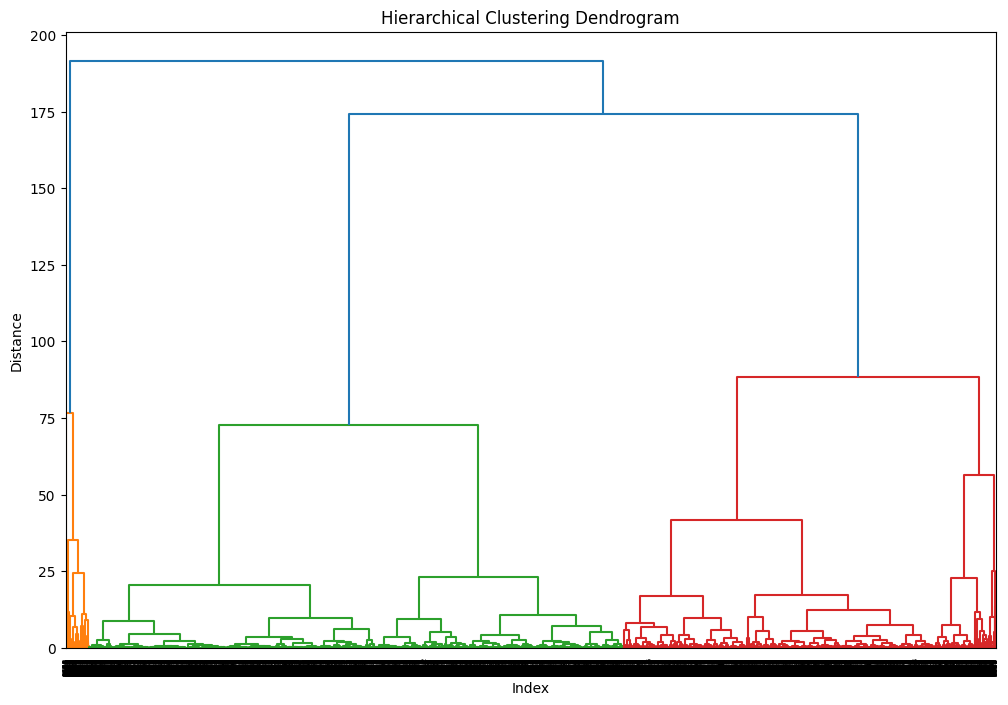

original_label  legitimate  phishing
cluster_label                       
0                     5000      4753
1                        0       247


In [19]:
hclust = AgglomerativeClustering(n_clusters=2, linkage='ward')
hclust_labels = hclust.fit_predict(X_pca1)

plt.figure(figsize=(12, 8))
dendrogram(linkage(X_pca1, method='ward'))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Index')
plt.ylabel('Distance')
plt.show()


# Create a DataFrame with the original labels and the cluster labels
hcluster_analysis = pd.DataFrame({
    'original_label': balanced_df1['label'],
    'cluster_label': hclust_labels
})

# Group by cluster label and count the occurrences of each original label
hcluster_label_counts = hcluster_analysis.groupby('cluster_label')['original_label'].value_counts().unstack(fill_value=0)

# Print the counts to see which cluster label corresponds to which original label
print(hcluster_label_counts)

**Here, we see that even hierarchical clustering fails for our dataset, where even the best parameters cannot identify the 2 clusters separately**